In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [6]:
data = []
labels = []
classes = 43  # Number of classes
cur_path = os.getcwd()

# Retrieve images and labels
for i in range(classes):
    path = os.path.join('/content/drive/MyDrive/GTSRB','Train', str(i))
    images = os.listdir(path)
    for img in images:
        try:
            image = Image.open(path + '/' + img)
            image = image.resize((30, 30))  # Resize to 30x30
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(e)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)


In [7]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0


In [8]:
!pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.6 MB/s eta 0:00:00


In [9]:
from deap import base, creator, tools, algorithms
import random

# Evaluation function for an individual
def evaluate_individual(individual):
    # Decode the hyperparameters
    filters_1 = individual[0]
    filters_2 = individual[1]
    kernel_size = (individual[2], individual[2])
    learning_rate = individual[3]
    batch_size = individual[4]

    # Define the CNN model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=filters_1, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.Conv2D(filters=filters_2, kernel_size=kernel_size, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model (reduced epochs for evaluation speed)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=3, validation_data=(X_test, y_test), verbose=0)

    # Get validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy,


In [10]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize validation accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_filter1", random.choice, [16, 32, 64, 128])  # Filters for the first Conv layer
toolbox.register("attr_filter2", random.choice, [16, 32, 64, 128])  # Filters for the second Conv layer
toolbox.register("attr_kernel", random.choice, [3, 5, 7])           # Kernel size
toolbox.register("attr_lr", random.uniform, 0.0001, 0.01)           # Learning rate
toolbox.register("attr_batch", random.choice, [16, 32, 64])         # Batch size

# Individual and population
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_filter1, toolbox.attr_filter2, toolbox.attr_kernel, toolbox.attr_lr, toolbox.attr_batch))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=128, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_individual)


In [11]:
# GA parameters
population = toolbox.population(n=10)  # Initial population size
NGEN = 5                               # Number of generations
CXPB, MUTPB = 0.5, 0.2                # Crossover and mutation probabilities

# Run the Genetic Algorithm
for gen in range(NGEN):
    print(f"Generation {gen + 1}")
    # Evaluate all individuals
    fitnesses = map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Select and generate new individuals
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Replace population with next generation
    population[:] = offspring

# Best individual
best_individual = tools.selBest(population, 1)[0]
print(f"Best hyperparameters: {best_individual}")


Generation 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 2
Generation 3
Generation 4
Generation 5
Best hyperparameters: [16, 93, 3, 0.003060158895301083, 27]


In [12]:
best_filters_1 = best_individual[0]
best_filters_2 = best_individual[1]
best_kernel = (best_individual[2], best_individual[2])
best_lr = best_individual[3]
best_batch_size = best_individual[4]

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=best_filters_1, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(filters=best_filters_2, kernel_size=best_kernel, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=best_batch_size, epochs=15, validation_data=(X_test, y_test))


Epoch 1/15
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.6524 - loss: 1.3668 - val_accuracy: 0.9521 - val_loss: 0.1792
Epoch 2/15
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9678 - loss: 0.1103 - val_accuracy: 0.9685 - val_loss: 0.1187
Epoch 3/15
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9789 - loss: 0.0738 - val_accuracy: 0.9549 - val_loss: 0.1946
Epoch 4/15
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9782 - loss: 0.0782 - val_accuracy: 0.9329 - val_loss: 0.4410
Epoch 5/15
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9793 - loss: 0.0836 - val_accuracy: 0.9741 - val_loss: 0.1085
Epoch 6/15
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9856 - loss: 0.0527 - val_accuracy: 0.9764 - val_loss: 0.1611
Epoch 7/15
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9878 - loss: 0.0538 - val_accuracy: 0.9791 - val_loss: 0.1188
Epoch 8/15
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9923 - loss: 0.0

In [13]:
model.save('traffic_classifier_optimized.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


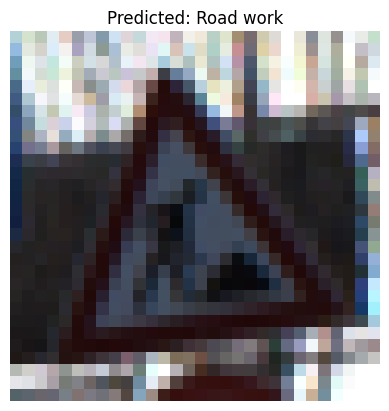

The predicted class is: Road work


In [17]:
# Load the trained model
from tensorflow.keras.models import load_model

model = load_model('traffic_classifier_optimized.h5')

# Define traffic sign labels
classes = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)',
    9: 'No passing', 10: 'No passing vehicles >3.5 metric tons', 11: 'Right of way at intersection',
    12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles >3.5 tons prohibited',
    17: 'No entry', 18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right',
    21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right',
    25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing',
    29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing',
    32: 'End of speed + passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead',
    35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight or left', 38: 'Keep right',
    39: 'Keep left', 40: 'Roundabout mandatory', 41: 'End of no passing', 42: 'End no passing >3.5 tons'
}

# Function to predict a new image
def predict_new_image(img_path):
    img = Image.open(img_path).resize((30, 30))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    prediction = np.argmax(model.predict(img_array))
    plt.imshow(img)
    plt.title(f"Predicted: {classes[prediction]}")
    plt.axis('off')
    plt.show()
    return classes[prediction]

# Test with a new image
img_path = '11623.png'  # Update with your image path
predicted_class = predict_new_image(img_path)
print(f"The predicted class is: {predicted_class}")
